# Deep Clustering for Municipality of Breda
## A deep learning approach for neighborhood clustering

Resource: https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf

## DATA
The data files can be downloaded [HERE](https://github.com/PsDragon/Portfolio_new/raw/main/Download%20files/dataframe_Breda.xlsx)

## 1. Data Preparation

This section describes the common data preprocessing steps required for clustering. We load the packages, the data, check for outliers, selecting features, rescale the features, and handling missing data. 

### 1.1 Loading Packages

In [ ]:
# loading the packages
from time import time
import keras.backend as K
from tensorflow.keras.layers import Dense, Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler, MaxAbsScaler, minmax_scale, QuantileTransformer, PowerTransformer
from sklearn.cluster import KMeans
import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.utils import plot_model
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from scipy import stats
import seaborn as sns

%matplotlib inline

### 1.2 Loading Data

In [ ]:
# Import the excel file into Pandas DataFrame
data = pd.read_excel(r"C:\Users\anouk\Downloads\dataframe_Breda.xlsx")
data.head()

,neighborhood_name,- Laag [%] [2020],- Midden [%] [2020],- Hoog [%] [2020],Huurwoningen [%],Koopwoningen [%],Eigendom onbekend [%],Woningen met bouwjaar tot 2000 [%],Woningen met bouwjaar vanaf 2000 [%],Huurwoningen in bezit van woningcorporaties [%],...,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_meergezins_woningen,aantal_mannen,aantal_vrouwen,aantal_inwoners,green_score,livability_score,percentage_huurwoningen
0,Valkenberg,0.14,0.41,0.46,0.69,0.30,0.01,0.83,0.17,0.34,...,8.333333,23.421053,26.666667,46.200000,36.034483,36.896552,72.758621,26.487179,2.201133,66.956522
1,Chassé,0.08,0.24,0.67,0.51,0.49,0.01,0.56,0.44,0.21,...,11.388889,14.814815,28.529412,44.843750,43.026316,40.540541,83.026316,16.188406,2.303931,50.666667
2,Fellenoord,0.31,0.40,0.28,0.81,0.15,0.04,0.91,0.09,0.57,...,10.714286,23.846154,35.789474,35.625000,45.000000,45.526316,80.000000,18.869953,2.004738,77.142857
3,Schorsmolen,0.13,0.37,0.50,0.79,0.20,0.01,0.84,0.16,0.46,...,7.500000,36.428571,66.086957,96.304348,71.400000,65.600000,137.200000,14.803241,1.828105,80.909091
4,Station,0.14,0.35,0.51,0.79,0.21,0.00,0.52,0.48,0.42,...,15.000000,17.800000,42.800000,42.800000,43.269231,39.464286,79.821429,15.095238,2.144758,78.333333


In [ ]:
data.shape

(41, 104)

### 1.3 Outliers

In [ ]:
# Define a boxplot to see the outliers
def plot_boxplot(df, ft):
    df.boxplot(column=[ft])
    plt.grid(False)
    plt.show

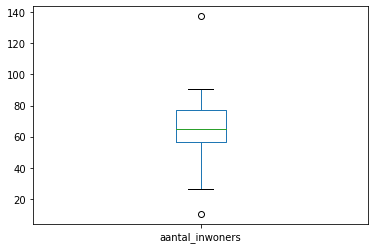

In [ ]:
# Plot ToewijzingBedrag in boxplot
plot_boxplot(data, 'aantal_inwoners')

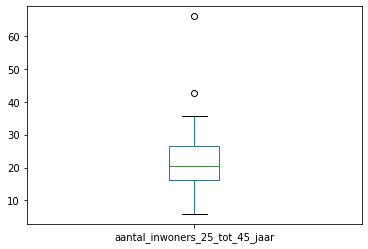

In [ ]:
# Plot ToewijzingBedrag in boxplot
plot_boxplot(data, 'aantal_inwoners_25_tot_45_jaar')

There are many outliers, but these outliers are not bad data points. They are the most important data of all, because the outliers seperates the neighborhoods. 

### 1.4 Selecting Features

It can be seen from the DataFrame above that neighborhood_name field is unique for each neighborhood data record. This field with unique values is not useful for clustering and it contains string values and thus can be dropped:

In [ ]:
data_x = data.drop(['neighborhood_name'], axis=1)

### 1.5 Rescaling Features

It can also be seen from the DataFrame that the ranges of values are very different for different fields/features. It is well known that K-means is sensitive to the scale of feature values because it uses Euclidean distance as similarity metrics. To avoid this issue, the values of all features are rescaled into the range of [0, 1]:


I tried multiple scalers. I runned everything 5 times with each scaler. The best options are:



1. **MinMaxScaler** : 3 of the 5 runs were the bad neighborhoods correct clustered. 
2.   **Normalizer** : 2 of the 5 runs were the bad neighborhoods correct clustered. 
3.   **MaxAbsScaler** : 2 of the 5 runs were the bad neighborhoods correct clustered. 



In [ ]:
numeric_columns = data_x.columns.values.tolist()

In [ ]:
X = data_x[numeric_columns]

In [ ]:
data_x[numeric_columns] = MinMaxScaler().fit_transform(X) #MaxAbsScaler()

In [ ]:
data_x.head()

,- Laag [%] [2020],- Midden [%] [2020],- Hoog [%] [2020],Huurwoningen [%],Koopwoningen [%],Eigendom onbekend [%],Woningen met bouwjaar tot 2000 [%],Woningen met bouwjaar vanaf 2000 [%],Huurwoningen in bezit van woningcorporaties [%],Huurwoningen in bezit overige verhuurders [%],...,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_meergezins_woningen,aantal_mannen,aantal_vrouwen,aantal_inwoners,green_score,livability_score,percentage_huurwoningen
0,0.162162,0.708333,0.596154,0.81250,0.220588,0.25,0.83,0.17,0.459459,0.568966,...,0.120130,0.586124,0.345761,0.392367,0.446549,0.492056,0.491569,0.572275,0.547910,0.466221
1,0.000000,0.000000,1.000000,0.53125,0.500000,0.25,0.56,0.44,0.283784,0.465517,...,0.340368,0.312290,0.376676,0.375919,0.555967,0.556541,0.572579,0.238178,0.690044,0.203077
2,0.621622,0.666667,0.250000,1.00000,0.000000,1.00,0.91,0.09,0.770270,0.379310,...,0.291744,0.599650,0.497167,0.264120,0.586854,0.644771,0.548702,0.325168,0.276362,0.630769
3,0.135135,0.541667,0.673077,0.96875,0.073529,0.25,0.84,0.16,0.621622,0.534483,...,0.060065,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.193242,0.032139,0.691608
4,0.162162,0.458333,0.692308,0.96875,0.088235,0.00,0.52,0.48,0.567568,0.603448,...,0.600649,0.407273,0.613518,0.351134,0.559769,0.537495,0.547293,0.202715,0.469963,0.650000


In [ ]:
data_x.shape

(41, 103)

### 1.6 Handling Missing Data

The following code is to check if any missing data exists in the dataset:

In [ ]:
data_x.isnull().sum()

- Laag [%] [2020]          0
- Midden [%] [2020]        0
- Hoog [%] [2020]          0
Huurwoningen [%]           0
Koopwoningen [%]           0
                          ..
aantal_vrouwen             0
aantal_inwoners            0
green_score                0
livability_score           0
percentage_huurwoningen    0
Length: 103, dtype: int64

The above table shows that there are no missing values!

## 2. Implementation of the DEC Method in Keras

The DEC algorithm will be implemented in Keras as follows:

**Step 1**: Estimating the number of clusters

**Step 2**: Creating and training a K-means model

**Step 3**: Creating and training an autoencoder

**Step 4**: Implementing DEC Soft Labeling

**Step 5**: Creating a new DEC model

**Step 6**: Training the New DEC Model

**Step 7**: Using the Trained DEC Model for Predicting Clustering Classes

**Step 8**: Jointly Refining DEC Model

**Step 9**: Using Refined DEC Model for Predicting Clustering Classes

**Step 10**: Comparing with K-means

### 2.1 Estimating the Number of Clusters

The DEC method combines Autoencoder with K-means and other machine learning techniques. In order to train a K-means model, an estimated number of clusters is required. The number of clusters is estimated in this notebook by exploring the silhouette values of different K-means model executions:

In [ ]:
# first we need to define x in order to estimate the number of clusters
x = data_x.values
x.shape

(41, 103)

In [ ]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score(x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.3039385489652667)
For n_clusters = 3, Kmeans silhouette score is 0.27609681865642677)
For n_clusters = 4, Kmeans silhouette score is 0.22595069498932402)
For n_clusters = 5, Kmeans silhouette score is 0.1992061309677804)
For n_clusters = 6, Kmeans silhouette score is 0.19666597405089495)
For n_clusters = 7, Kmeans silhouette score is 0.19846958194494535)
For n_clusters = 8, Kmeans silhouette score is 0.1647156083191889)
For n_clusters = 9, Kmeans silhouette score is 0.1825612619739505)


A silhouette value measures how similar a data record is to its own cluster (cohesion) compared to other clusters. The silhouette value ranges from −1 to +1, where a high value indicates that the data record matches to its own cluster well and matches poorly to its neighboring clusters.

The silhouette values above indicate that the top two choices of the number of clusters are 2 and 3. The number of clusters of 4 is chosen in this notebook.

### 2.2 Creating and Training K-means Model

Once the number of clusters is determined, a K-means model can be created:

In [ ]:
n_clusters = 4 # n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
y_pred_kmeans = kmeans.fit_predict(x)

### 2.3 Creating and Training Autoencoder

In addition to K-means, an autoencoder is required as well in the DEC algorithm. The following function is to create an autoencoder:

In [ ]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model

An autoencoder model is created as follows:

In [ ]:
n_epochs   = 10
batch_size = 32
dims = [x.shape[-1], 500, 500, 2000, 103] 
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir = r'C:\Users\anouk\Downloads\results'
autoencoder, encoder = autoencoder(dims, init=init)

The diagram of the resulting encoder model can be created as below:

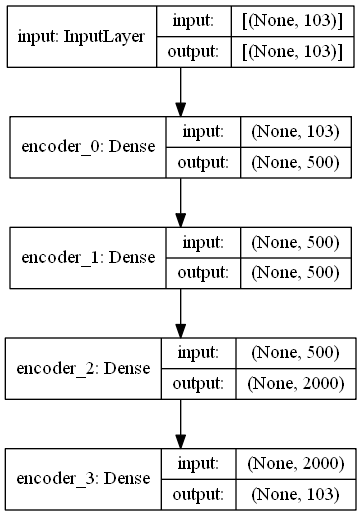

In [ ]:
plot_model(encoder, to_file=r'C:\Users\anouk\Downloads\encoder.png', show_shapes=True)
Image(filename=r'C:\Users\anouk\Downloads\encoder.png') 

The diagram of the resulting auto encoder model can be created as below:

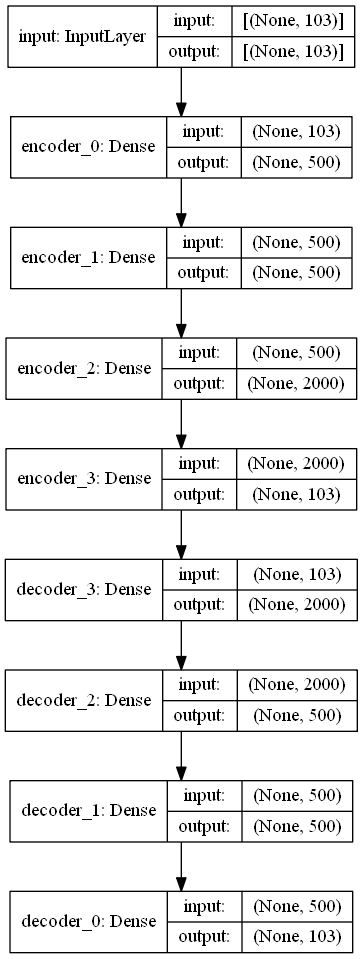

In [ ]:
plot_model(autoencoder, to_file=r'C:\Users\anouk\Downloads\autoencoder.png', show_shapes=True)
Image(filename=r'C:\Users\anouk\Downloads\autoencoder.png') 

The autoencoder is trained as follows:

In [ ]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)

Epoch 1/10
2/2 [==============================] - 0s 10ms/step - loss: 0.2268
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.2027
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 0.1612
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.1134
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0702
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0516
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0718
Epoch 8/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0653
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0558
Epoch 10/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0520


The weights of the trained autoencoder are saved for later usage:

In [ ]:
autoencoder.save_weights(save_dir + '/ae_weights.h5')
autoencoder.load_weights(save_dir + '/ae_weights.h5')

### 2.4 Implementing DEC Soft Labeling

One of the key components in the DEC method is soft labeling, that is, assigning an estimated class to each of the data samples in such a way that it can be refined iteratively. To this end, a new ClusteringLayer class is defined:

In [ ]:
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### 2.5 Creating New DEC Model

Once the soft labeling layer is defined, it can be used to form a DEC model as follows:

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

A diagram of the new DEC model can be created as below:

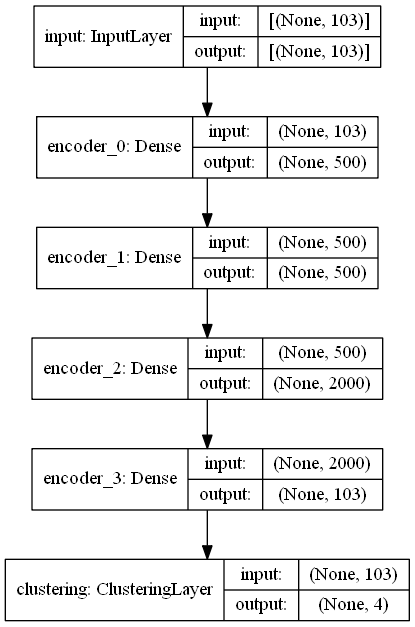

In [ ]:
plot_model(model, to_file=r'C:\Users\anouk\Downloads\model.png', show_shapes=True)
Image(filename=r'C:\Users\anouk\Downloads\model.png') 

The new DEC model can be compiled as follows:

In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### 2.6 Training the New DEC Model

The new DEC model is trained iteratively:

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T
loss = 0
index = 0
maxiter = 1000 
update_interval = 100 
tol = 0.001 # tolerance threshold to stop training
index_array = np.arange(x.shape[0])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

The training procedure above iteratively refines the clusters by learning from the high confidence assignments with the help of the auxiliary target distribution function target_distribution(). 

Specifically, the DEC model is trained by matching the soft assignment to the target distribution. 

To this end, in the DEC model the objective/loss function is defined as a Kullback-Leibler (KL) divergence loss between the soft assignments and the auxiliary distribution.



The model weights of the trained model are saved for later usage:

In [ ]:
model.save_weights(save_dir + '/DEC_model_final.h5')
model.load_weights(save_dir + '/DEC_model_final.h5')

### 2.7 Jointly Refining DEC Model

The main idea behind the DEC method is to simultaneously learn the feature representations and cluster assignments using deep neural networks. 

To this end, the following code uses the pre-trained autoencoder and K-means model to define a new model that takes the preprocessed Breda neighborhood dataset as input and output both the predicted clustering classes and decoded input data records.

We first need to re-run the autoencoder function.

In [ ]:
# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir + '/ae_weights.h5')

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

The diagram of the joined model can be created as follows:

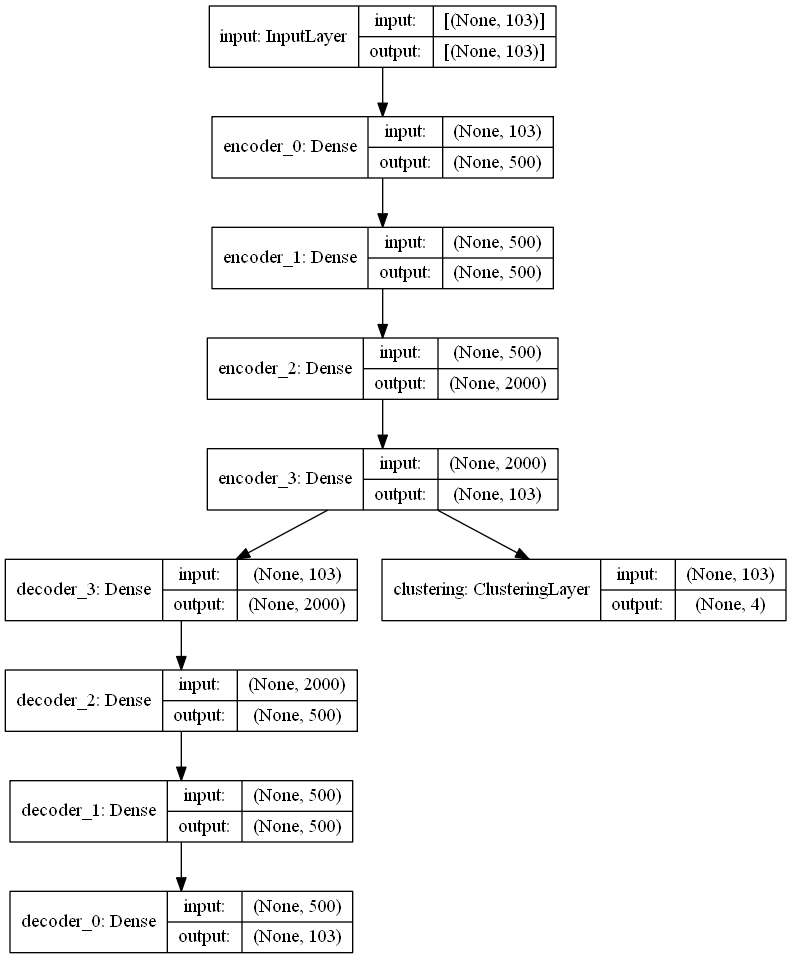

In [ ]:
plot_model(model, to_file=r'C:\Users\anouk\Downloads\model.png', show_shapes=True)
Image(filename=r'C:\Users\anouk\Downloads\model.png') 

The refinement of the DEC model is performed as follows:

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  
        y_pred = q.argmax(1)
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

delta_label  0.0 < tol  0.001
Reached tolerance threshold. Stopping training.


The jointly refined model weights are saved:

In [ ]:
model.save_weights(save_dir + '/b_DEC_model_final.h5')
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### 2.8 Using Refined DEC Model for Predicting Clustering Classes

The following code is to use the refined DEC model for predicting clustering classes:

In [ ]:
# evaluation of model prediction 
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)

The code below can be used to reuse the t-SNE embedded two dimensional space (vis_x, vis_y) and use the color coding of the new predicted clustering labels to visualize the new predicted clustering result:

### 2.8.1 TSNE

C:\Users\anouk\anaconda3\envs\DeepLearning_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\anouk\anaconda3\envs\DeepLearning_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


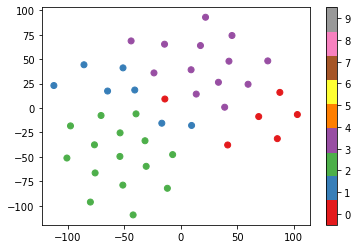

In [ ]:
x_embedded = TSNE(n_components=2, init='pca').fit_transform(x)
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("Set1", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

**Figure 2**: Clustering of the refined DEC model

A silhouette score is obtained as follows:

In [ ]:
# For n_clusters = 3, Deep clustering silhouette score is 0.29138845064227953)
# For n_clusters = 4, Deep clustering silhouette score is 0.28032271072644543)
# For n_clusters = 10, Deep clustering silhouette score is 0.19216022223500343)
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 4, Deep clustering silhouette score is 0.18391634681086633)


### 2.9 Comparing with K-means

Figure 3 shows the result of clustering by K-means. By comparing Figure 3 with Figure 2, we can see that K-means achieved relatively higher silhouette score. However, it can be seen that the refined DEC model predicted clusters with more clearly separable boundaries.

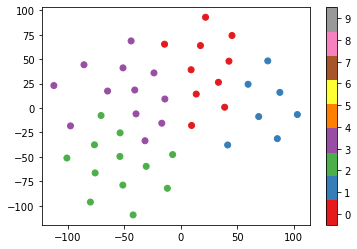

In [ ]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("Set1", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

**Figure 3**: Clustering of the K-means model

A silhouette score is obtained as follows:

In [ ]:
# For n_clusters = 3, Kmeans silhouette score is 0.3723536590701517)
# For n_clusters = 4, Kmeans silhouette score is 0.3215079773343314)
# For n_clusters = 10, Kmeans silhouette score is 0.34194939183619716)
# centers = kmeans.cluster_centers_
score = silhouette_score (x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 4, Kmeans silhouette score is 0.2098192081150075)


### 2.10 Clustered DataFrame

Here we will assign the clusters to the neighborhoods to see if we can cluster the bad neighborhoods in the same cluster. 

#### 2.10.1 DEC Model

In [ ]:
data_tsne = data_x.copy()
data_tsne['cluster'] = y_pred
data_tsne['cluster'].value_counts()

2    15
3    13
1     7
0     6
Name: cluster, dtype: int64

In [ ]:
tsne_df = pd.DataFrame(data = x_embedded, columns = ['pca1', 'pca2'])
tsne_df = pd.concat((tsne_df, data_tsne['cluster']), axis = 1)
clustered_tsne = pd.concat([tsne_df, data], axis = 1)
clustered_vulnerable_neighborhoods_tsne = clustered_tsne.loc[clustered_tsne['neighborhood_name'].isin(['Geeren-noord', 'Geeren-zuid', 'Schorsmolen', 'Heuvel', 'Kesteren', 'Haagpoort', 'Tuinzigt', 'Doornbos-Linie', 'Fellenoord', 'Biesdonk', 'Wisselaar', 'Brabantpark'])]
clustered_vulnerable_neighborhoods_tsne

,pca1,pca2,cluster,neighborhood_name,- Laag [%] [2020],- Midden [%] [2020],- Hoog [%] [2020],Huurwoningen [%],Koopwoningen [%],Eigendom onbekend [%],...,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_meergezins_woningen,aantal_mannen,aantal_vrouwen,aantal_inwoners,green_score,livability_score,percentage_huurwoningen
2,76.941795,48.284470,3,Fellenoord,0.31,0.40,0.28,0.81,0.15,0.04,...,10.714286,23.846154,35.789474,35.625000,45.000000,45.526316,80.000000,18.869953,2.004738,77.142857
3,85.411369,-31.314960,0,Schorsmolen,0.13,0.37,0.50,0.79,0.20,0.01,...,7.500000,36.428571,66.086957,96.304348,71.400000,65.600000,137.200000,14.803241,1.828105,80.909091
7,42.557121,47.978546,3,Doornbos-Linie,0.27,0.37,0.36,0.67,0.33,0.00,...,11.860465,13.039216,25.593220,30.735294,34.230769,34.083333,63.235294,25.580671,1.946361,62.727273
8,45.247875,74.281334,3,Biesdonk,0.40,0.41,0.19,0.60,0.40,0.00,...,17.717391,13.163265,24.411765,57.222222,43.148148,46.944444,88.454545,26.436157,1.813122,60.750000
9,21.812624,92.966164,3,Geeren-zuid,0.45,0.38,0.17,0.81,0.19,0.00,...,19.117647,12.352941,25.714286,48.863636,38.478261,43.152174,78.645833,29.296183,1.804861,76.410256
10,17.319021,63.988552,3,Wisselaar,0.43,0.41,0.16,0.57,0.43,0.00,...,13.627451,12.261905,21.153846,30.000000,33.606557,35.327869,68.606557,28.530181,1.873543,63.157895
11,38.766121,0.860049,3,Geeren-noord,0.40,0.45,0.15,0.69,0.31,0.00,...,15.333333,12.500000,20.540541,39.722222,35.897436,35.512821,71.410256,27.943452,1.908764,68.888889
13,33.236015,26.388628,3,Brabantpark,0.24,0.41,0.35,0.57,0.43,0.01,...,13.186813,15.982143,22.773438,24.854369,30.000000,32.314815,59.298246,27.310904,2.211949,55.533981
23,9.018489,39.207779,3,Haagpoort,0.34,0.29,0.37,0.65,0.35,0.00,...,15.476190,13.043478,30.625000,20.416667,43.125000,44.583333,87.500000,18.530372,1.981029,70.588235
24,13.569821,14.317430,3,Heuvel,0.37,0.35,0.28,0.68,0.32,0.00,...,15.405405,12.916667,30.639535,39.464286,43.089888,42.640449,85.730337,21.622316,2.055487,68.611111


In [ ]:
cluster_table = pd.concat((pca_df, clustered_tsne['neighborhood_name']), axis = 1)
cluster_table.to_excel(r"C:\Users\anouk\Downloads\clustered_neighborhoods.xlsx")

In [ ]:
vulnerable_neighborhoods = cluster_table.loc[cluster_table['neighborhood_name'].isin(['Geeren-noord', 'Geeren-zuid', 'Schorsmolen', 'Heuvel', 'Kesteren', 'Haagpoort', 'Tuinzigt', 'Doornbos-Linie', 'Fellenoord', 'Biesdonk', 'Wisselaar', 'Brabantpark'])]
vulnerable_neighborhoods.to_excel(r"C:\Users\anouk\Downloads\vulnerable_neighborhoods.xlsx")

#### 2.10.2 K-Means

In [ ]:
data_kmeans = data_x.copy()
data_kmeans['cluster'] = y_pred_kmeans
pca_df_kmeans = pd.DataFrame(data = x_embedded, columns = ['pca1', 'pca2'])
pca_df_kmeans = pd.concat((pca_df_kmeans, data_kmeans['cluster']), axis = 1)
pca_df_kmeans['cluster'].value_counts()

3    12
2    12
0    10
1     7
Name: cluster, dtype: int64

In [ ]:
data_kmeans = pd.read_excel(r"C:\Users\anouk\Downloads\dataframe_Breda.xlsx")

In [ ]:
clustered_kmeans = pd.concat([pca_df_kmeans, data_kmeans], axis = 1)

In [ ]:
clustered_kmeans.loc[clustered_kmeans['neighborhood_name'].isin(['Geeren-noord', 'Geeren-zuid', 'Schorsmolen', 'Heuvel', 'Kesteren', 'Haagpoort', 'Tuinzigt', 'Doornbos-Linie', 'Fellenoord', 'Biesdonk', 'Wisselaar', 'Brabantpark'])]

,pca1,pca2,cluster,neighborhood_name,- Laag [%] [2020],- Midden [%] [2020],- Hoog [%] [2020],Huurwoningen [%],Koopwoningen [%],Eigendom onbekend [%],...,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_meergezins_woningen,aantal_mannen,aantal_vrouwen,aantal_inwoners,green_score,livability_score,percentage_huurwoningen
2,76.941795,48.284470,1,Fellenoord,0.31,0.40,0.28,0.81,0.15,0.04,...,10.714286,23.846154,35.789474,35.625000,45.000000,45.526316,80.000000,18.869953,2.004738,77.142857
3,85.411369,-31.314960,1,Schorsmolen,0.13,0.37,0.50,0.79,0.20,0.01,...,7.500000,36.428571,66.086957,96.304348,71.400000,65.600000,137.200000,14.803241,1.828105,80.909091
7,42.557121,47.978546,0,Doornbos-Linie,0.27,0.37,0.36,0.67,0.33,0.00,...,11.860465,13.039216,25.593220,30.735294,34.230769,34.083333,63.235294,25.580671,1.946361,62.727273
8,45.247875,74.281334,0,Biesdonk,0.40,0.41,0.19,0.60,0.40,0.00,...,17.717391,13.163265,24.411765,57.222222,43.148148,46.944444,88.454545,26.436157,1.813122,60.750000
9,21.812624,92.966164,0,Geeren-zuid,0.45,0.38,0.17,0.81,0.19,0.00,...,19.117647,12.352941,25.714286,48.863636,38.478261,43.152174,78.645833,29.296183,1.804861,76.410256
10,17.319021,63.988552,0,Wisselaar,0.43,0.41,0.16,0.57,0.43,0.00,...,13.627451,12.261905,21.153846,30.000000,33.606557,35.327869,68.606557,28.530181,1.873543,63.157895
11,38.766121,0.860049,0,Geeren-noord,0.40,0.45,0.15,0.69,0.31,0.00,...,15.333333,12.500000,20.540541,39.722222,35.897436,35.512821,71.410256,27.943452,1.908764,68.888889
13,33.236015,26.388628,0,Brabantpark,0.24,0.41,0.35,0.57,0.43,0.01,...,13.186813,15.982143,22.773438,24.854369,30.000000,32.314815,59.298246,27.310904,2.211949,55.533981
23,9.018489,39.207779,0,Haagpoort,0.34,0.29,0.37,0.65,0.35,0.00,...,15.476190,13.043478,30.625000,20.416667,43.125000,44.583333,87.500000,18.530372,1.981029,70.588235
24,13.569821,14.317430,0,Heuvel,0.37,0.35,0.28,0.68,0.32,0.00,...,15.405405,12.916667,30.639535,39.464286,43.089888,42.640449,85.730337,21.622316,2.055487,68.611111


### 3. Summary

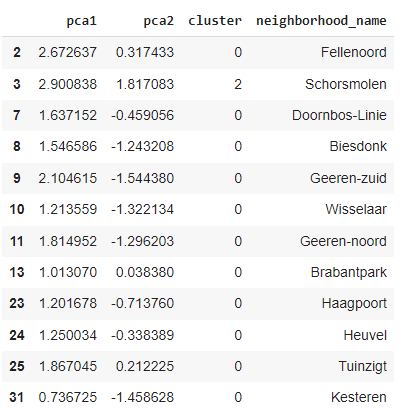

**Figure 4**: DEC Model


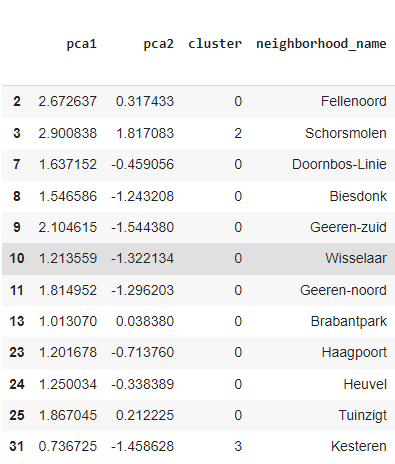

**Figure 5**: K-Means Model

The model evaluation results demonstrated that the new refined DEC model predicted clusters of the bad neighborhoods correct compared with the K-means method. The K-means method did not cluster the bad neighborhoods together while the new DEC model did sometimes cluster the bad neighborhoods together. This new DEC model has the potential of being used for neighborhood clustering.